# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
import time
from scipy.interpolate import PchipInterpolator
import scipy
from collections import defaultdict

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from itertools import chain

# Data (Tension) b/t = 0.5

In [ ]:
df = pd.read_csv("../files/data/Corner_Crack_CS2/Small_Cracks_CS_bt0d5.csv", index_col=False)
df = df[df['a/t'] > 0.5]
df = df[df['a/t'] < 1]
df = df.drop(columns=["b/t"])

df_ = pd.read_csv("../files/data/Corner_Crack_CS2/SUBSET_2.csv", index_col=False)
df_ = df_[df_['a/t'] > 0.5]
df_ = df_[df_['a/t'] < 1]
df_ = df_.drop(columns=["b/t"])
df = pd.concat([df, df_], axis=0, ignore_index=True)

df_ = pd.read_csv("../files/data/Corner_Crack_CS2/SUBSET_1.csv")
df_ = df_[df_['a/t'] > 0.5]
df_ = df_[df_['a/t'] < 1]
df_ = df_.drop(columns=["b/t"])
df = pd.concat([df, df_], axis=0, ignore_index=True)

df_ = pd.read_csv("../files/data/Corner_Crack_CS2/SINGLE_DATABASES_CS_ThroughThickn.csv")
df_ = df_[df_['a/t'] > 0.5]
df_ = df_[df_['a/t'] < 1]
df_ = df_.drop(columns=["b/t"])
df = pd.concat([df, df_], axis=0, ignore_index=True)

df

,W/R,a/c,a/t,r/t,phi,K-T,K-B,K-P
0,40.0,0.1,0.60,5.0,0.00006,1.429000,1.135000,0.188200
1,40.0,0.1,0.60,5.0,0.00012,1.468000,1.166000,0.193300
2,40.0,0.1,0.60,5.0,0.00017,1.496000,1.188000,0.197000
3,40.0,0.1,0.60,5.0,0.00023,1.515000,1.203000,0.199400
4,40.0,0.1,0.60,5.0,0.00029,1.527000,1.212000,0.201100
...,...,...,...,...,...,...,...,...
4900515,2.6,10.0,0.95,3.0,0.63566,-0.001630,0.000061,-0.000805
4900516,2.6,10.0,0.95,3.0,0.63570,-0.001565,0.000059,-0.000773
4900517,2.6,10.0,0.95,3.0,0.63574,0.001275,-0.000048,0.000630
4900518,2.6,10.0,0.95,3.0,0.63577,0.002804,-0.000105,0.001385


In [40]:
# Get unique combinations of the first four columns
# CC_combinations = df.iloc[:, :5].drop_duplicates().to_numpy()
CC_combinations = df.iloc[:, :4].drop_duplicates().to_numpy()

print(len(CC_combinations))

10437


In [31]:
print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
print("Different a/c values: ", np.unique(CC_combinations[:,1], axis=0))
print("Different a/t values: ", np.unique(CC_combinations[:,2], axis=0))
print("Different r/t values: ", np.unique(CC_combinations[:,3], axis=0))
# print("Different r/t values: ", np.unique(CC_combinations[:,4], axis=0))

Different W/r values:  [  2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2   5.8   6.4   7.    8.
   9.   10.   12.   16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a/t values:  [0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [0.5 1.  1.5 2.  3.  5. ]


In [32]:
d = df.to_numpy()

# Build a mapping from combination to indices
comb_to_indices = defaultdict(list)
for idx, row in enumerate(d):
    comb = tuple(row[:4])
    comb_to_indices[comb].append(idx)

# Convert lists to numpy arrays for faster indexing
for comb in comb_to_indices:
    comb_to_indices[comb] = np.array(comb_to_indices[comb])

CC_phi_regular_64 = np.linspace(0.052, 1.52, 64)
CC_K_regular_64 = np.zeros((len(CC_combinations), len(CC_phi_regular_64)))

valid_combs = []
for i, combination in enumerate(CC_combinations):
    comb_tuple = tuple(combination)
    indices = comb_to_indices.get(comb_tuple, np.array([]))
    if indices.size == 0:
        continue  # No data for this combination

    phi_vals = d[indices][:, 4]
    K_vals = d[indices][:, 5]

    phi_min = phi_vals.min() + 0.035
    phi_max = phi_vals.max() - 0.035

    # Filter indices where phi values lie within [phi_min, phi_max]
    filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

    phi_vals = d[filtered_indices][:,4]
    K_vals = d[filtered_indices][:,5]
    phi_idxes = np.argsort(phi_vals)

    if len(phi_idxes) >= 16:
        monotonic_phi_idxes = [phi_idxes[0]]
        prev_phi = phi_vals[phi_idxes[0]]
        for index in phi_idxes[1:]:
            now_phi = phi_vals[index]
            if now_phi > prev_phi:
                monotonic_phi_idxes.append(index)
                prev_phi = phi_vals[index]
        
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)

        # Interpolate as usual
        interpolated = interp_func(CC_phi_regular_64)
        # Set to zero where phi > phi_max
        interpolated[CC_phi_regular_64 > phi_max] = 0.0
        CC_K_regular_64[i, :] = interpolated

        valid_combs.append(i)

In [33]:
CC_combinations = CC_combinations[valid_combs]
CC_K_regular_64 = CC_K_regular_64[valid_combs]

CC_combinations.shape, CC_K_regular_64.shape

((10437, 4), (10437, 64))

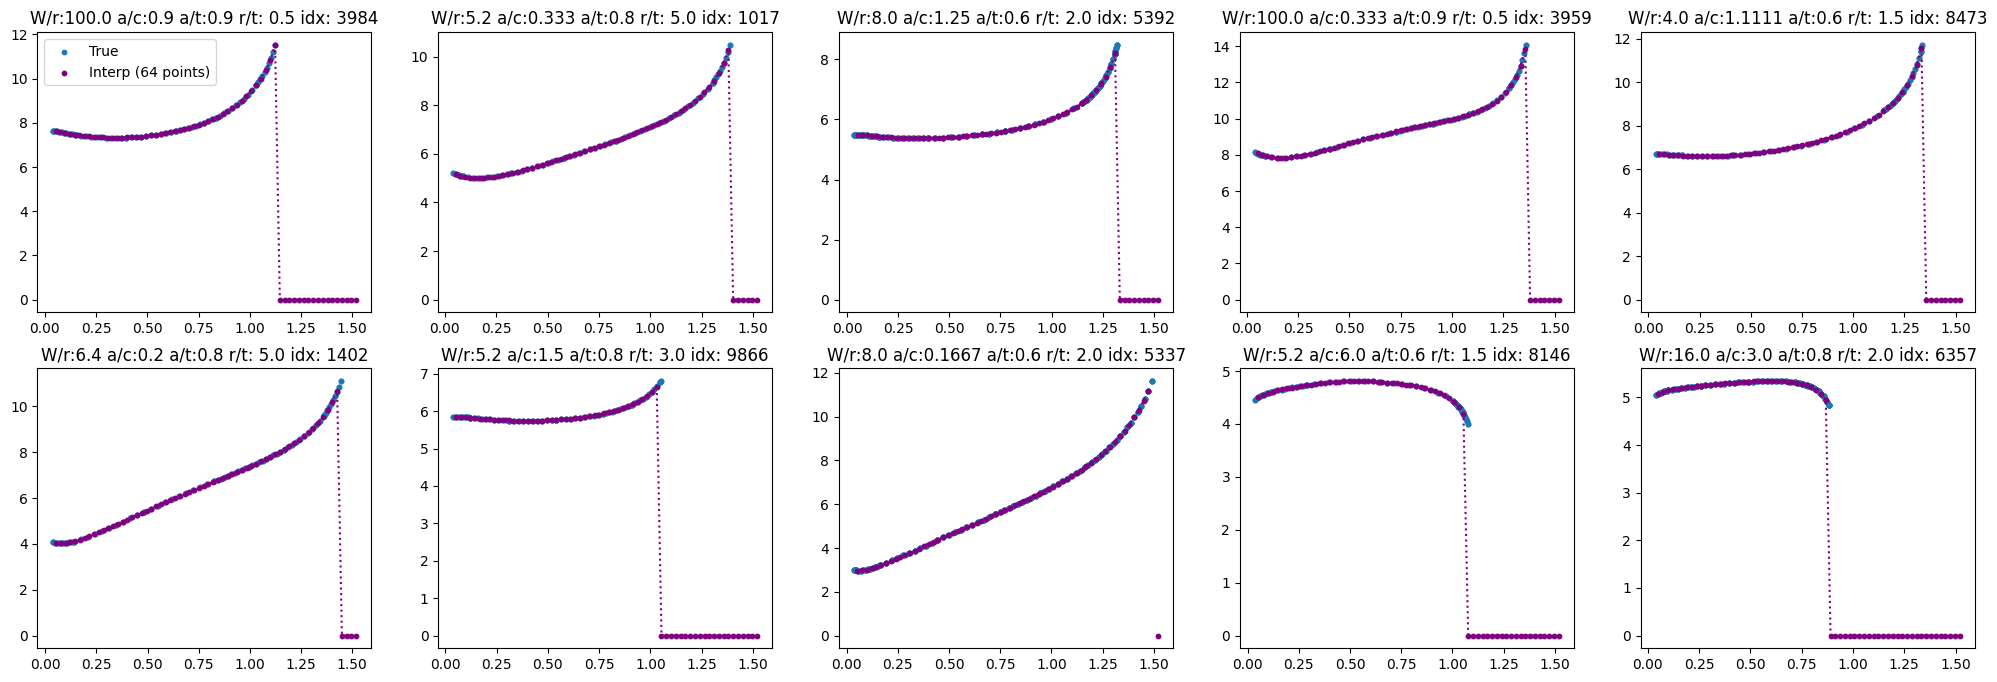

In [38]:
# np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(25,8))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(CC_combinations))
        combination = CC_combinations[idx]
        indices = np.where((d[:, 0] == combination[0]) & 
                        (d[:, 1] == combination[1]) &
                        (d[:, 2] == combination[2]) &
                        (d[:, 3] == combination[3]))
        indices = indices[0]
        phi_vals = d[indices][:, 4]
        K_vals = d[indices][:, 5]

        phi_min = phi_vals.min() + 0.035
        phi_max = phi_vals.max() - 0.035

        # Filter indices where phi values lie within [phi_min, phi_max]
        filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

        axs[i,j].scatter(d[filtered_indices][:,4], d[filtered_indices][:,5], label="True", s=10)
        axs[i,j].scatter(CC_phi_regular_64, CC_K_regular_64[idx], label="Interp (64 points)", color='purple', s=10)
        axs[i,j].plot(CC_phi_regular_64, CC_K_regular_64[idx], color='purple', linestyle=":")
        axs[i,j].set_title("W/r:{} a/c:{} a/t:{} r/t: {} idx: {}".format(combination[0], combination[1], combination[2], combination[3], idx))
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

# Data (Tension) b/t = 0.5

In [41]:
df = pd.read_csv("../files/data/Corner_Crack_CS2/Small_Cracks_CS_bt0d5.csv", index_col=False)
df = df[df['a/t'] >= 1]
df = df.drop(columns=["b/t"])

df_ = pd.read_csv("../files/data/Corner_Crack_CS2/SUBSET_2.csv", index_col=False)
df_ = df_[df_['a/t'] >= 1]
df_ = df_.drop(columns=["b/t"])
df = pd.concat([df, df_], axis=0, ignore_index=True)

df_ = pd.read_csv("../files/data/Corner_Crack_CS2/SUBSET_1.csv")
df_ = df_[df_['a/t'] >= 1]
df_ = df_.drop(columns=["b/t"])
df = pd.concat([df, df_], axis=0, ignore_index=True)

df_ = pd.read_csv("../files/data/Corner_Crack_CS2/SINGLE_DATABASES_CS_ThroughThickn.csv")
df_ = df_[df_['a/t'] >= 1]
df_ = df_.drop(columns=["b/t"])
df = pd.concat([df, df_], axis=0, ignore_index=True)

df

,W/R,a/c,a/t,r/t,phi,K-T,K-B,K-P
0,40.0,0.25,1.1,1.0,0.00001,6.241,4.092,0.3698
1,40.0,0.25,1.1,1.0,0.00001,6.408,4.201,0.3797
2,40.0,0.25,1.1,1.0,0.00002,6.531,4.282,0.3870
3,40.0,0.25,1.1,1.0,0.00002,6.620,4.340,0.3923
4,40.0,0.25,1.1,1.0,0.00003,6.683,4.381,0.3960
...,...,...,...,...,...,...,...,...
3865424,2.6,10.00,15.0,3.0,0.58901,8.872,-4.148,4.0450
3865425,2.6,10.00,15.0,3.0,0.58902,8.749,-4.091,3.9880
3865426,2.6,10.00,15.0,3.0,0.58902,8.577,-4.011,3.9100
3865427,2.6,10.00,15.0,3.0,0.58903,8.342,-3.902,3.8030


In [42]:
# Get unique combinations of the first four columns
# CC_combinations = df.iloc[:, :5].drop_duplicates().to_numpy()
CC_combinations = df.iloc[:, :4].drop_duplicates().to_numpy()

print(len(CC_combinations))

14526


In [43]:
print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
print("Different a/c values: ", np.unique(CC_combinations[:,1], axis=0))
print("Different a/t values: ", np.unique(CC_combinations[:,2], axis=0))
print("Different r/t values: ", np.unique(CC_combinations[:,3], axis=0))
# print("Different r/t values: ", np.unique(CC_combinations[:,4], axis=0))

Different W/r values:  [  2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2   5.8   6.4   7.    8.
   9.   10.   12.   16.   20.   30.   40.  100. ]
Different a/c values:  [ 0.25    0.3333  0.5     0.6667  0.7502  0.8     0.9001  1.      1.1111
  1.25    1.3333  1.4993  2.      3.003   5.9988 10.    ]
Different a/t values:  [ 1.1   1.25  1.4   1.8   2.4   3.2   4.5   6.5  10.   15.  ]
Different r/t values:  [0.2   0.333 0.5   0.667 1.    1.5   2.    3.    5.   ]


In [44]:
d = df.to_numpy()

# Build a mapping from combination to indices
comb_to_indices = defaultdict(list)
for idx, row in enumerate(d):
    comb = tuple(row[:4])
    comb_to_indices[comb].append(idx)

# Convert lists to numpy arrays for faster indexing
for comb in comb_to_indices:
    comb_to_indices[comb] = np.array(comb_to_indices[comb])

CC_phi_regular_64 = np.linspace(0.052, 1.52, 64)
CC_K_regular_64 = np.zeros((len(CC_combinations), len(CC_phi_regular_64)))

valid_combs = []
for i, combination in enumerate(CC_combinations):
    comb_tuple = tuple(combination)
    indices = comb_to_indices.get(comb_tuple, np.array([]))
    if indices.size == 0:
        continue  # No data for this combination

    phi_vals = d[indices][:, 4]
    K_vals = d[indices][:, 5]

    phi_min = phi_vals.min() + 0.035
    phi_max = phi_vals.max() - 0.035

    # Filter indices where phi values lie within [phi_min, phi_max]
    filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

    phi_vals = d[filtered_indices][:,4]
    K_vals = d[filtered_indices][:,5]
    phi_idxes = np.argsort(phi_vals)

    if len(phi_idxes) >= 16:
        monotonic_phi_idxes = [phi_idxes[0]]
        prev_phi = phi_vals[phi_idxes[0]]
        for index in phi_idxes[1:]:
            now_phi = phi_vals[index]
            if now_phi > prev_phi:
                monotonic_phi_idxes.append(index)
                prev_phi = phi_vals[index]
        
        interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)

        # Interpolate as usual
        interpolated = interp_func(CC_phi_regular_64)
        # Set to zero where phi > phi_max
        interpolated[CC_phi_regular_64 > phi_max] = 0.0
        CC_K_regular_64[i, :] = interpolated

        valid_combs.append(i)

In [45]:
CC_combinations = CC_combinations[valid_combs]
CC_K_regular_64 = CC_K_regular_64[valid_combs]

CC_combinations.shape, CC_K_regular_64.shape

((14176, 4), (14176, 64))

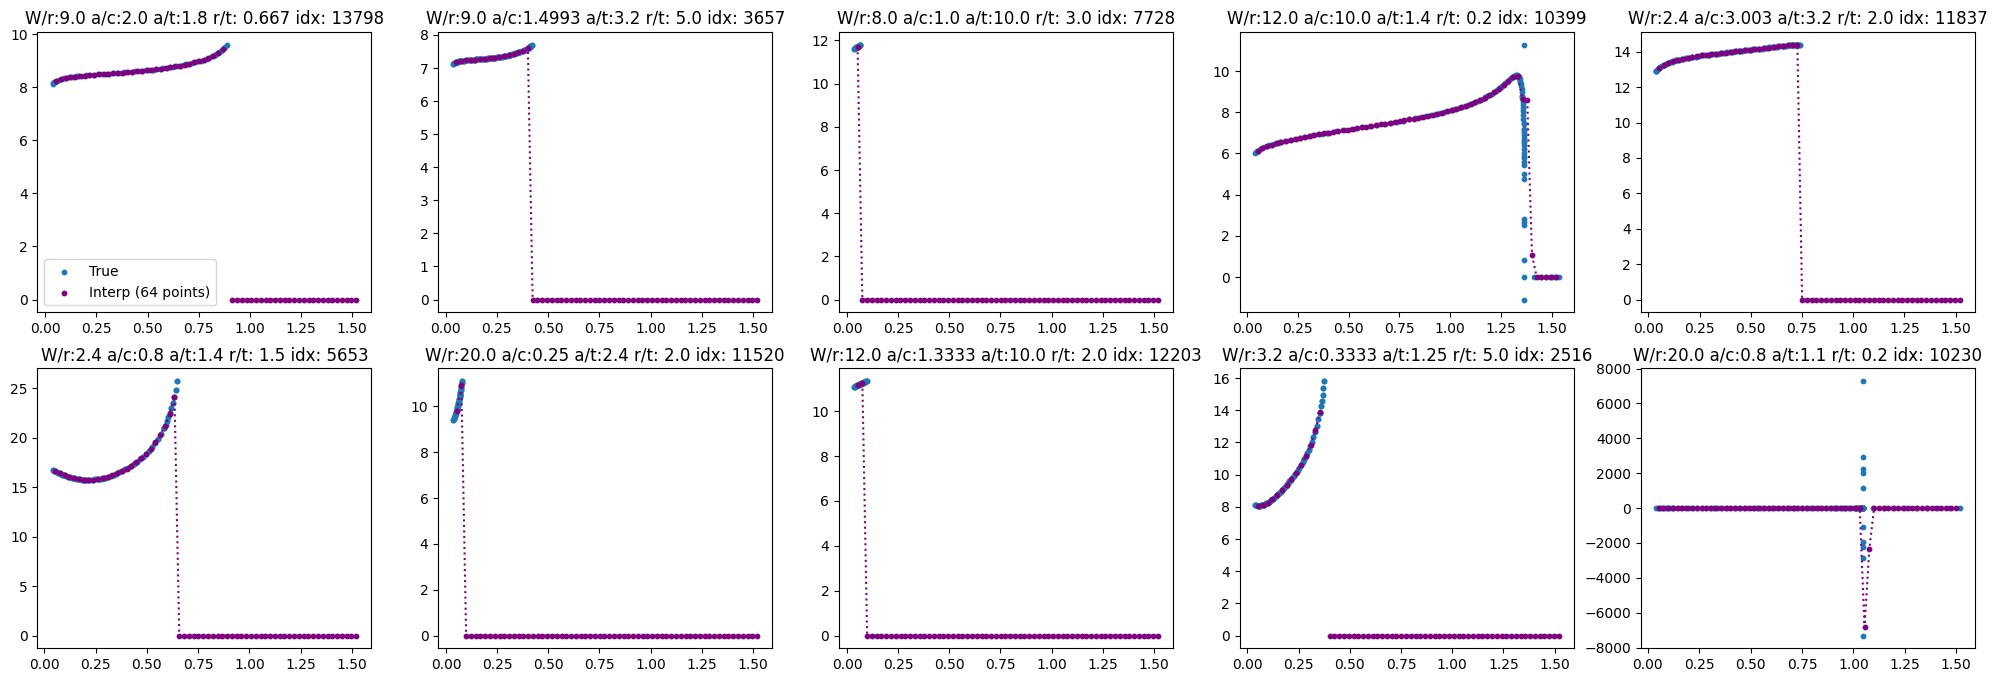

In [48]:
# np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(25,8))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(CC_combinations))
        combination = CC_combinations[idx]
        indices = np.where((d[:, 0] == combination[0]) & 
                        (d[:, 1] == combination[1]) &
                        (d[:, 2] == combination[2]) &
                        (d[:, 3] == combination[3]))
        indices = indices[0]
        phi_vals = d[indices][:, 4]
        K_vals = d[indices][:, 5]

        phi_min = phi_vals.min() + 0.035
        phi_max = phi_vals.max() - 0.035

        # Filter indices where phi values lie within [phi_min, phi_max]
        filtered_indices = indices[(phi_vals >= phi_min) & (phi_vals <= phi_max)]

        axs[i,j].scatter(d[filtered_indices][:,4], d[filtered_indices][:,5], label="True", s=10)
        axs[i,j].scatter(CC_phi_regular_64, CC_K_regular_64[idx], label="Interp (64 points)", color='purple', s=10)
        axs[i,j].plot(CC_phi_regular_64, CC_K_regular_64[idx], color='purple', linestyle=":")
        axs[i,j].set_title("W/r:{} a/c:{} a/t:{} r/t: {} idx: {}".format(combination[0], combination[1], combination[2], combination[3], idx))
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()